# Predictive Analytics: SPY ETF Price with Multivariate Linear Regression


### Project Introduction

My objective in this project is to use relevant data to build a multivariate linear regressional model that can accurately predict the price of the SPDR S&P 500 Trust ETF (SPY), which closely tracks the S&P 500 index.
 
After data wrangling and exploratory analysis are performed, relevant data will be fitted into linear regression models. I will then narrow down to the most important independent variables and come up with a sound linear regressional model. Data splitting into train, validation, and test datasets will be performed to evaluate the overall quality of the chosen model in predicting the SPY ETF price.

### Overview of Initial Data

    • SPY ETF Price: Adjusted daily closing price of the SPY ETF. This is the dependent variable. 
    • SPY Volume: Average daily trading volume of the SPY ETF.	
    • GLD Price: Adjusted daily closing price of SPDR Gold Trust that invests in physical gold. This is an alternative to the physical gold.	
    • CPI: Consumer price index readings reflect the level of inflation in the US.
    • GDP: US gross domestic product index	
    • FED Fund Rate: Federal Reserve fund rate as a tool to support monetary policies.	
    • Jobs Opening: Number of job openings in the US.	
    • Population: The population of the US.	
    • Unemployment Rate: US unemployment rate.	
    • PCE: Personal consumption expenditures, also known as consumer spending, is a measure of the spending on goods and services by Americans.	

### Analytics Approach

Key steps involve: 
  
   1. Data Collection, Cleaning, and Preprocessing
   
   I downloaded 10-year SPY ETF and GLD data via the R library tidyquant and the different economic data from FRED St. Louis FED https://fred.stlouisfed.org/. Originally, I used R for this project before replicating my work in Python. After data are downloaded and saved into csv files, the data will undergo the following steps:

• Data joining: Economic data will be joined together by month. Most of these economic data are reported monthly, except for GDP.

• Data aggregation: The adjusted closing prices and trading volumes of SPY and GLD are daily. Their monthly averages will be calculated to match the frequency of the monthly economic data before being joined with the economic data.

• NA filling: As the GDP data is measured and reported quarterly, for the months that are not reported, I fill in the NA with the average of the right after and right before quarterly GDP figures.

• Data normalization: As the variables are in different ranges/scales, I will normalize all the predictor variables (in ranges [0; 1]) before using them for multivariate linear regression to predict the average SPY price. 

   2. Exploratory Data Analysis

   I explore correlation of the variables to see what would make sense for the signs of coefficients when independent variables are fitted into linear regression to predict the dependent one. I will use data visualization to assist this step. No additional feature engineering is used. My economics knowledge and understanding of the dynamics of the stock market during the past 10 years (let's say the domain knowledge) help explain the movements and correlation.

   3. Model Building:
   
   I will start with all the nine predictor variables and use VIF and variable selection to deal with expected multicollinearity. After deciding on what predictor variables to keep, I will perform train-validation-test split on the transformed dataset.  

   4. Model Evaluation
   
   I will use R-squared (R2) and relevant plots to assess the model quality and make a conclusion.

### Modeling Results

A spoiler is that the chosen model uses six predictor variables after I remove two highly correlated variables and one statistically insignificant variable.

R2 of the train dataset fitted into the model is 0.969 while that of the validation dataset and that of the test dataset are 0.958 and 0.948, respectively. The coefficients are reasonable with the actual correlation between SPY price and the six variables. The Residual vs Fitted graph and the Q-Q residuals graph show no heteroscedasticity and virtually normally distributed residuals.

Overall, the model perform wells in predicting the average monthly SPY ETF price. Future research can incorporate longer time period data, additional predictor variables, feature engineering, and other machine learning models.

Please see my Python code implementation and more details below.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mpl_dates
from matplotlib.dates import YearLocator

# Data loading
SPY = pd.read_csv("SPY.csv")
GLD = pd.read_csv("GLD.csv")
CPI = pd.read_csv("US CPI - Consumer Price Index.csv")
GDP = pd.read_csv("US GDP.csv")
FED_rate = pd.read_csv("US FED Funds Rate.csv")
Job_Openings = pd.read_csv("US Job Openings Total Nonfarm.csv")
PCE = pd.read_csv("US PCE - Personal Consumption Expenditure.csv")
Pop = pd.read_csv("US Population.csv")
U_rate = pd.read_csv("US Unemployment Rate.csv")

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Data preprocessing
# Economic data joining
data = CPI.merge(GDP, on="DATE", how="left").merge(FED_rate, on="DATE", how="left")
data = data.merge(Job_Openings, on="DATE", how ="left").merge(PCE, on="DATE", how="left")
data = data.merge(Pop, on="DATE", how="left").merge(U_rate, on="DATE", how="left")
data["Month"] = pd.to_datetime(data["DATE"]).dt.strftime("%Y-%m")
# Column renaming
data.rename(columns={"CPIAUCSL": "CPI", "NC000334Q": "GDP", "FEDFUNDS": "FEDRATE", "JTSJOL": "JO", "PCEPI": "PCE", "POPTHM": "POP", "UNRATE": "UNRATE", "Month": "MONTH"}, inplace=True)
data

,DATE,CPI,GDP,FEDRATE,JO,PCE,POP,UNRATE,MONTH
0,2014-02-01,235.547,NaN,0.07,4373.0,96.660,318642.0,6.7,2014-02
1,2014-03-01,236.028,NaN,0.08,4388.0,96.815,318827.0,6.7,2014-03
2,2014-04-01,236.468,96.586,0.09,4566.0,96.987,319020.0,6.2,2014-04
3,2014-05-01,236.918,NaN,0.09,4747.0,97.147,319225.0,6.3,2014-05
4,2014-06-01,237.231,NaN,0.10,4982.0,97.253,319438.0,6.1,2014-06
...,...,...,...,...,...,...,...,...,...
116,2023-10-01,307.531,122.919,5.33,8685.0,121.319,335773.0,3.8,2023-10
117,2023-11-01,308.024,NaN,5.33,8931.0,121.307,335925.0,3.7,2023-11
118,2023-12-01,308.742,NaN,5.33,8889.0,121.451,336070.0,3.7,2023-12
119,2024-01-01,309.685,NaN,5.33,8863.0,121.870,336194.0,3.7,2024-01


In [3]:
SPY["month"] = pd.to_datetime(SPY["date"]).dt.strftime("%Y-%m")
GLD["month"] = pd.to_datetime(GLD["date"]).dt.strftime("%Y-%m")

# Data aggregation to calculate the average monthly prices and volumes of SPY and GLD
SPY_by_month = SPY.groupby("month").agg({"adjusted": "mean", "volume": "mean"}).reset_index().rename(columns={"month": "MONTH", "adjusted": "AVG_PRICE", "volume": "AVG_VOLUME"})
GLD_by_month = GLD.groupby("month").agg({"adjusted": "mean"}).reset_index().rename(columns={"month": "MONTH", "adjusted": "GLD_PRICE"})

# Continued data joining - between economic data and SPY and GLD data
data = data.merge(SPY_by_month, on="MONTH", how="left").merge(GLD_by_month, on="MONTH", how="left")
data

,DATE,CPI,GDP,FEDRATE,JO,PCE,POP,UNRATE,MONTH,AVG_PRICE,AVG_VOLUME,GLD_PRICE
0,2014-02-01,235.547,NaN,0.07,4373.0,96.660,318642.0,6.7,2014-02,151.296784,1.260097e+08,125.386316
1,2014-03-01,236.028,NaN,0.08,4388.0,96.815,318827.0,6.7,2014-03,155.447836,1.216231e+08,128.600952
2,2014-04-01,236.468,96.586,0.09,4566.0,96.987,319020.0,6.2,2014-04,155.699052,1.117096e+08,125.134285
3,2014-05-01,236.918,NaN,0.09,4747.0,97.147,319225.0,6.3,2014-05,158.095541,8.481399e+07,124.065714
4,2014-06-01,237.231,NaN,0.10,4982.0,97.253,319438.0,6.1,2014-06,163.161950,7.976416e+07,123.469048
...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-10-01,307.531,122.919,5.33,8685.0,121.319,335773.0,3.8,2023-10,422.625340,9.087044e+07,177.749999
117,2023-11-01,308.024,NaN,5.33,8931.0,121.307,335925.0,3.7,2023-11,442.081819,7.142670e+07,184.041904
118,2023-12-01,308.742,NaN,5.33,8889.0,121.451,336070.0,3.7,2023-12,465.077879,8.215540e+07,188.541000
119,2024-01-01,309.685,NaN,5.33,8863.0,121.870,336194.0,3.7,2024-01,477.327879,8.098242e+07,188.073332


In [4]:
# Handling missing GDP values with imputation
data.loc[0, "GDP"] = np.mean([95.89, data.loc[2, "GDP"]])
data.loc[1, "GDP"] = np.mean([95.89, data.loc[2, "GDP"]])
data.loc[117:, "GDP"] = data.loc[116, "GDP"]
data.loc[118:, "GDP"] = data.loc[116, "GDP"]
data.loc[119:, "GDP"] = data.loc[116, "GDP"]

for i in range(2, 114, 3):
    data.loc[i+1, "GDP"] = np.mean([data.loc[i, "GDP"], data.loc[i+3, "GDP"]])
    data.loc[i+2, "GDP"] = np.mean([data.loc[i, "GDP"], data.loc[i+3, "GDP"]])

# delete the last row that lack economic data (JO, PCE, POP) to make total 120 records only
data.drop(index=120, inplace=True)
data

,DATE,CPI,GDP,FEDRATE,JO,PCE,POP,UNRATE,MONTH,AVG_PRICE,AVG_VOLUME,GLD_PRICE
0,2014-02-01,235.547,96.2380,0.07,4373.0,96.660,318642.0,6.7,2014-02,151.296784,1.260097e+08,125.386316
1,2014-03-01,236.028,96.2380,0.08,4388.0,96.815,318827.0,6.7,2014-03,155.447836,1.216231e+08,128.600952
2,2014-04-01,236.468,96.5860,0.09,4566.0,96.987,319020.0,6.2,2014-04,155.699052,1.117096e+08,125.134285
3,2014-05-01,236.918,96.6665,0.09,4747.0,97.147,319225.0,6.3,2014-05,158.095541,8.481399e+07,124.065714
4,2014-06-01,237.231,96.6665,0.10,4982.0,97.253,319438.0,6.1,2014-06,163.161950,7.976416e+07,123.469048
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-09-01,307.288,122.8565,5.33,9307.0,121.267,335612.0,3.8,2023-09,436.095966,7.943366e+07,177.428001
116,2023-10-01,307.531,122.9190,5.33,8685.0,121.319,335773.0,3.8,2023-10,422.625340,9.087044e+07,177.749999
117,2023-11-01,308.024,122.9190,5.33,8931.0,121.307,335925.0,3.7,2023-11,442.081819,7.142670e+07,184.041904
118,2023-12-01,308.742,122.9190,5.33,8889.0,121.451,336070.0,3.7,2023-12,465.077879,8.215540e+07,188.541000


In [5]:
# Normalization function
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Perform predictor variable normalization and then concat with the SPY data to come up wiht the data_normalized dataset 
data_normalized = data[["CPI", "GDP", "FEDRATE", "JO", "PCE", "POP", "UNRATE", "AVG_VOLUME", "GLD_PRICE"]].apply(normalize)
data_normalized = pd.concat([data[["DATE", "MONTH", "AVG_PRICE"]], data_normalized], axis=1)
data_normalized

,DATE,MONTH,AVG_PRICE,CPI,GDP,FEDRATE,JO,PCE,POP,UNRATE,AVG_VOLUME,GLD_PRICE
0,2014-02-01,2014-02,151.296784,0.010675,0.000000,0.003788,0.000000,0.000238,0.000000,0.289474,0.347129,0.268070
1,2014-03-01,2014-03,155.447836,0.017094,0.000000,0.005682,0.001921,0.006385,0.010540,0.289474,0.327151,0.305326
2,2014-04-01,2014-04,155.699052,0.022966,0.013043,0.007576,0.024715,0.013206,0.021536,0.245614,0.282002,0.265149
3,2014-05-01,2014-05,158.095541,0.028971,0.016060,0.007576,0.047893,0.019551,0.033216,0.254386,0.159513,0.252764
4,2014-06-01,2014-06,163.161950,0.033147,0.016060,0.009470,0.077987,0.023755,0.045351,0.236842,0.136515,0.245849
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-09-01,2023-09,436.095966,0.968014,0.997658,1.000000,0.631835,0.976087,0.966841,0.035088,0.135010,0.871206
116,2023-10-01,2023-10,422.625340,0.971256,1.000000,1.000000,0.552183,0.978149,0.976014,0.035088,0.187096,0.874938
117,2023-11-01,2023-11,442.081819,0.977835,1.000000,1.000000,0.583685,0.977673,0.984674,0.026316,0.098544,0.947858
118,2023-12-01,2023-12,465.077879,0.987416,1.000000,1.000000,0.578307,0.983384,0.992935,0.026316,0.147406,1.000000


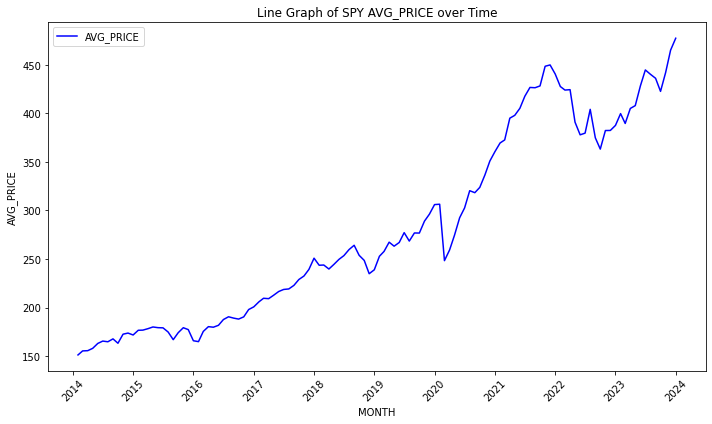

In [6]:
# Now perform Exploratory Data Analysis

# Plotting line graph of AVG_PRICE over time with customized axis settings
data_normalized["MONTH"] = pd.to_datetime(data_normalized["MONTH"])

plt.figure(figsize=(10, 6))
plt.plot(data_normalized["MONTH"], data_normalized["AVG_PRICE"], color="blue", label="AVG_PRICE")
plt.xlabel("MONTH")
plt.ylabel("AVG_PRICE")
plt.title("Line Graph of SPY AVG_PRICE over Time")

# Customize x-axis tick labels to show only years and rotate by 45 degrees
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator(base=1))  # Set tick locator to show one label per year
plt.xticks(rotation=45)

plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# The graph shows over time the SPY ETF price increases despite certain choppy fluctuations.
# This makes sense; the US economy has been growing.

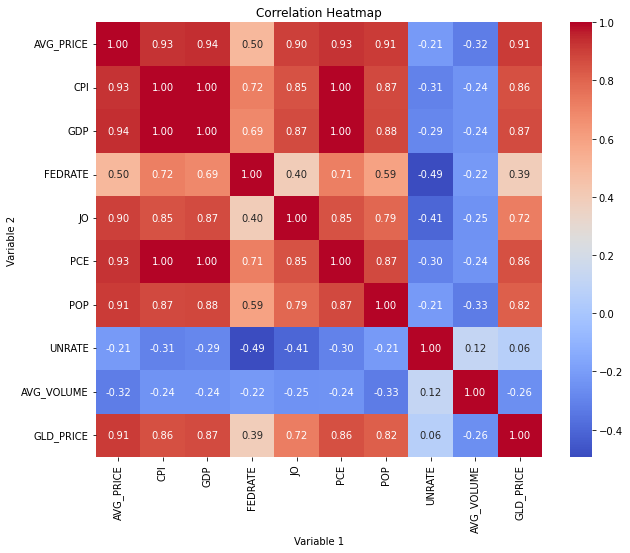

In [7]:
# Now explore correlation between variables.

# Correlation matrix
correlation_matrix = data_normalized.iloc[:, 2:].corr()
# Correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.show()

# From this matrix, multicollinearity is expected.

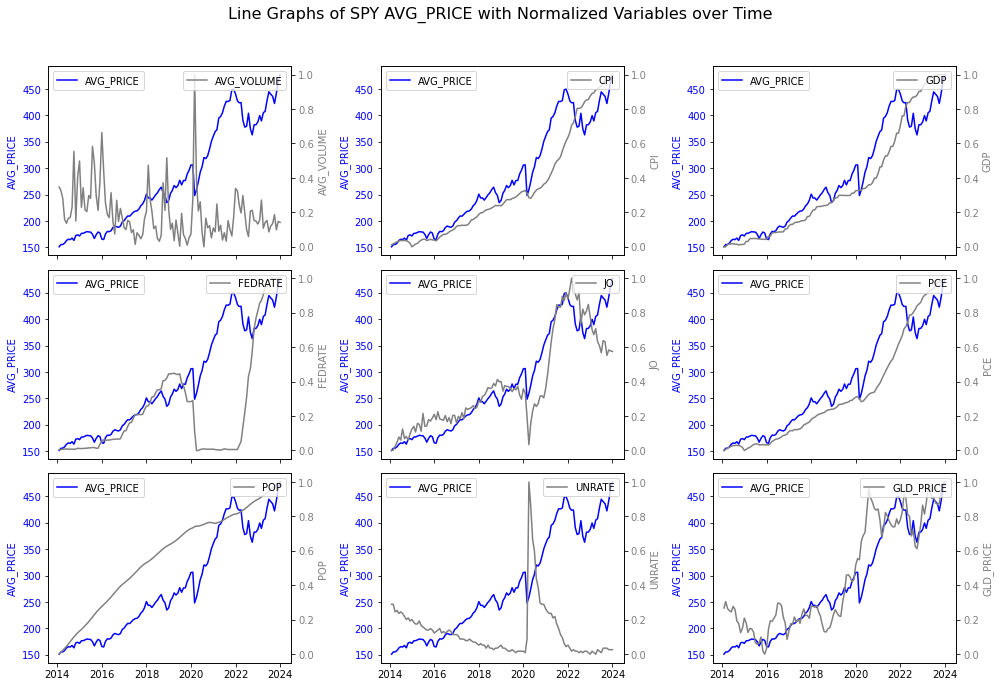

In [8]:
# Plot a grid of SPY AVG_PRICE with each of the normalized variables
# to observe the correlation of SPY Price with each predictor variable over the time period.

# Extract relevant columns
cols = ["AVG_VOLUME", "CPI", "GDP", "FEDRATE", "JO", "PCE", "POP", "UNRATE", "GLD_PRICE"]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 10), sharex=True)

# Plotting line graphs of AVG_PRICE with each normalized variable over time
for idx, col in enumerate(cols):
    row, col_index = divmod(idx, 3)  # Calculate the row and column index for subplot placement
    ax = axes[row, col_index]

    # Plot SPY AVG_PRICE on the left axis
    ax.plot(data_normalized["MONTH"], data_normalized["AVG_PRICE"], color="blue", label="AVG_PRICE")
    ax.set_ylabel("AVG_PRICE", color="blue")
    ax.tick_params(axis="y", labelcolor="blue") 

    # Create a secondary y-axis for normalized variable
    ax2 = ax.twinx()

    # Plot the normalized variable on the right axis
    ax2.plot(data_normalized["MONTH"], data_normalized[col], label=col, color="grey")
    ax2.set_ylabel(col, color="grey")
    ax2.tick_params(axis="y", labelcolor="grey")

    # Set x-axis tick labels to display only every two years
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(YearLocator(base=2))

    # Add legend for both axes
    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

# Set overall title and adjust layout
plt.suptitle("Line Graphs of SPY AVG_PRICE with Normalized Variables over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the subplot layout to make room for suptitle
plt.show()

### My insights and exploratory data analysis from the grid of line graphs
•	SPY price vs. SPY volume

The SPY volume tends to spike in periods when the SPY price experiences sharp declines. On the other hand, in periods when the SPY price increases steadily, the SPY volume fluctuates mildly. Behavioral finance can explain this. When stock prices decrease sharply, investors become fearful and want to sell stocks before other investors do to preserve their wealth. Stop-loss orders set up as part of risk management are also triggered, accelerating the price decline and trading volumes.

•	SPY price vs. GDP, CPI, PCE

The patterns of GDP, CPI, and PCE to SPY price are very similar. Their movements to SPY become more erratic from 2020 before converging in early 2024. This can be explained by the impact of FED fund rate changes on the S&P 500 since 2020 as a response to COVID-19.

•	SPY price and FED fund rate

In March 2020, both the SPY price and FED fund rate plunged due to the rapidly expanding COVID-19 pandemic. As the risk of lockdown and economic activity stoppage became elevated, investors sold their equity shares, causing the decline in the SPY price.

To support the economy, the FED lowered interest rates to 0%/0.25% and kept this rate low until early 2022.
Under that low interest rate environment that makes costs of borrowings and equity premium lower and thanks to the successful discovery and fast manufacturing of COVID-19 vaccines later in 2020, economic activities quickly recovered, the SPY price rose sharply. Then as inflation (measured by CPI) ran out of control, in 2022 the FED began rapidly increasing interest rates to combat it.

Increases in interest rates contract economic activities and lower equity multiples. As a result, the SPY price fell until the breakthrough in Artificial Intelligence with OpenAI ChatGPT fueling optimism in future productivity increases and economic growth. The slowdown of inflation also helped boost SPY price targets as when inflation is under control, the FED will lower interest rates to foster economic activities.

•	SPY price and GLD price

GLD tends to outperform SPY during periods of economic uncertainty (for example, during the COVID-19 spread in 2020) as investors look for safe assets. Although there can be contradictory movements between them, in the long term they both increase in value and positively correlate with each other.

•	SPY price and number of jobs opening

Larger numbers of jobs opening signal economic booms, and during economic expansion, SPY price also rises as companies experience profitability increases. However, there is a divergence between them starting 2023. As jobs opening continued to decrease due to tightening monetary policies (FED rate hikes since 2022) in 2023, SPY recovered its 2022 selloff and climbed higher thanks to economic optimism from AI breakthrough (e.g., large language models like OpenAI ChatGPT) and continued GDP growth.

•	SPY price and population

A higher population means more labor in the workforce fosters economic activities, increasing stock prices.

•	SPY price and unemployment rate

The few months in 2020 were extreme with high unemployment rates due to COVID-19 lockdowns. This also supports the general negative correlation between unemployment and SPY price. High unemployment rates mean the economy is in contraction, lowering business profitability and SPY price.


In [9]:
# Now let's model it. Linear regression model with all the 9 predictor variables
model = sm.OLS(data_normalized["AVG_PRICE"], sm.add_constant(data_normalized[["AVG_VOLUME", "CPI", "GDP", "FEDRATE", "JO", "PCE", "POP", "UNRATE", "GLD_PRICE"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AVG_PRICE   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     448.7
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           2.19e-82
Time:                        20:50:42   Log-Likelihood:                -502.26
No. Observations:                 120   AIC:                             1025.
Df Residuals:                     110   BIC:                             1052.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        161.1135      9.543     16.883      0.0

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


##### High level of multicollinearity results in extreme coefficients, the signs of some of which even contradict the correlation.
##### Despite the high R2, the model is not good yet.

In [11]:
# Calculate Variance Inflation Factor (VIF) to find out which variables should be removed to deal with multicollinearity.
vif_data = sm.add_constant(data_normalized[["AVG_VOLUME", "CPI", "GDP", "FEDRATE", "JO", "PCE", "POP", "UNRATE", "GLD_PRICE"]])
vif_series = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns)
print("Variance Inflation Factors:")
print(vif_series[1:])

Variance Inflation Factors:
AVG_VOLUME       1.264137
CPI           4313.204043
GDP            806.343546
FEDRATE         17.189660
JO              21.901783
PCE           6376.082061
POP              7.605192
UNRATE           3.871767
GLD_PRICE       14.274626
dtype: float64


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [12]:
# PCE and CPI have extreme VIF values. Let's remove them from the model.
# Rerun the linear regression model withou PCE and CPI
model = sm.OLS(data_normalized["AVG_PRICE"], sm.add_constant(data_normalized[["AVG_VOLUME", "GDP", "FEDRATE", "JO", "POP", "UNRATE", "GLD_PRICE"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AVG_PRICE   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     467.5
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           8.93e-80
Time:                        20:50:43   Log-Likelihood:                -515.55
No. Observations:                 120   AIC:                             1047.
Df Residuals:                     112   BIC:                             1069.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.3648      8.870     15.374      0.0

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [13]:
# The coefficients look much better (much smaller than before)
# , but the coefficient of FEDRATE contradicts its correrlation with SPY AVG_PRICE.
# Also, FEDRATE is statistically insignificant. Let's remove it.
# Rerun the linear regression model with FEDRATE dropped
model = sm.OLS(data_normalized["AVG_PRICE"], sm.add_constant(data_normalized[["AVG_VOLUME", "GDP", "JO", "POP", "UNRATE", "GLD_PRICE"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AVG_PRICE   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     545.2
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           6.03e-81
Time:                        20:50:43   Log-Likelihood:                -516.09
No. Observations:                 120   AIC:                             1046.
Df Residuals:                     113   BIC:                             1066.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.2244      6.414     20.305      0.0

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [14]:
# The coefficients look very good.
# Now let's recalculate VIF values of the remaining six predictor variables.
vif_data = sm.add_constant(data_normalized[["AVG_VOLUME", "GDP", "JO", "POP", "UNRATE", "GLD_PRICE"]])
vif_series = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns)
print("Variance Inflation Factors:")
print(vif_series[1:])

Variance Inflation Factors:
AVG_VOLUME     1.164508
GDP           11.217649
JO             4.698326
POP            5.105466
UNRATE         2.236879
GLD_PRICE      7.723958
dtype: float64


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [15]:
# VIF values are much smaller now. Although some are larger than 5 (some multicollinearity remains), I am good with this. 

In [16]:
# Set seed for reproducibility before performing train-validation-test split.
np.random.seed(68)

# Splitting data into train, validation, and test sets
mask_train = np.random.choice(data_normalized.index, size=int(len(data_normalized) * 0.6), replace=False)
train = data_normalized.loc[mask_train]

remaining = data_normalized.drop(mask_train)

mask_val = np.random.choice(remaining.index, size=int(len(remaining) / 2), replace=False)
validate = remaining.loc[mask_val]
test = remaining.drop(mask_val)

# Linear regression model on the train data set
model = sm.OLS(train["AVG_PRICE"], sm.add_constant(train[["AVG_VOLUME", "GDP", "JO", "POP", "UNRATE", "GLD_PRICE"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AVG_PRICE   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     341.0
Date:                Wed, 24 Apr 2024   Prob (F-statistic):           4.07e-47
Time:                        20:50:43   Log-Likelihood:                -311.99
No. Observations:                  72   AIC:                             638.0
Df Residuals:                      65   BIC:                             653.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        131.2449      8.355     15.708      0.0

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


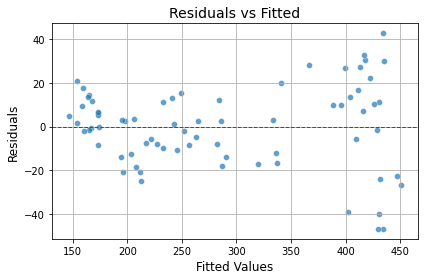

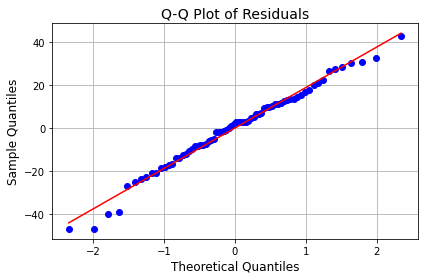

In [17]:
# Calculate residuals
residuals = results.resid

# Fitted values
fitted = results.fittedvalues

# Plotting Residuals vs Fitted with some R-style aesthetics
plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Fitted", fontsize=14)
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q plot of Residuals
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# The Residual vs Fitted and the Q-Q residuals graphs show no heteroscedasticity and virtually normally distributed residuals.

In [18]:
# Predictions and evaluation on validation set
pred_val = results.predict(sm.add_constant(validate[["AVG_VOLUME", "GDP", "JO", "POP", "UNRATE", "GLD_PRICE"]]))
SST_val = np.sum((validate["AVG_PRICE"] - np.mean(validate["AVG_PRICE"])) ** 2)
SSE_val = np.sum((pred_val - validate["AVG_PRICE"]) ** 2)
R2_val = 1 - SSE_val / SST_val
print("R-squared (Validation Set):", R2_val)

# Predictions and evaluation on test set
pred_test = results.predict(sm.add_constant(test[["AVG_VOLUME", "GDP", "JO", "POP", "UNRATE", "GLD_PRICE"]]))
SST_test = np.sum((test["AVG_PRICE"] - np.mean(test["AVG_PRICE"])) ** 2)
SSE_test = np.sum((pred_test - test["AVG_PRICE"]) ** 2)
R2_test = 1 - SSE_test / SST_test
print("R-squared (Test Set):", R2_test)

R-squared (Validation Set): 0.9583202471538597
R-squared (Test Set): 0.9478618385127938


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


R2 of the train dataset fitted into the model is 0.969 while that of the validation dataset and that of the test dataset are 0.958 and 0.948, respectively.

Overall, the model perform wells in predicting the average monthly SPY ETF price.